# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.  
And easily use below features:
1. Transforms for dictionary format data.
2. Load Nifti image with metadata.
3. Add channel dim to the data if no channel dimension.
4. Scale medical image intensity with expected range.
5. Crop out a batch of balanced images based on positive / negative label ratio.
6. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
7. Sliding window inference method.
8. Determinism training for reproducibility.

The training Spleen dataset is from http://medicaldecathlon.com/
![spleen](http://medicaldecathlon.com/img/spleen0.png)
Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# assumes the framework is found here, change as necessary
sys.path.append("..")
import monai
import monai.transforms.compose as transforms
from monai.transforms.composables import \
    LoadNiftid, AddChanneld, ScaleIntensityRanged, RandCropByPosNegLabeld, RandAffined
from monai.data.utils import list_data_collate
from monai.utils.sliding_window_inference import sliding_window_inference
from monai.metrics.compute_meandice import compute_meandice

monai.config.print_config()

MONAI version: 0.0.1
Python version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31)  [GCC 7.3.0]
Numpy version: 1.17.4
Pytorch version: 1.4.0a0+a5b4d78
Ignite version: 0.3.0


## Set MSD Spleen dataset path

In [2]:
data_root = '/workspace/data/medical/spleen'
train_images = glob.glob(os.path.join(data_root, 'imagesTr', '*.nii'))
train_labels = glob.glob(os.path.join(data_root, 'labelsTr', '*.nii'))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [3]:
train_transforms = transforms.Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', size=(96, 96, 96), pos=1,
                           neg=1, num_samples=4, image_key='image', image_threshold=0),
    # user can also add other random transforms
    # RandAffined(keys=['image', 'label'], spatial_size=(96, 96, 96), prob=0.5,
    #             rotate_range=(np.pi / 15, np.pi / 15, np.pi / 15), scale_range=(0.1, 0.1, 0.1))
])
val_transforms = transforms.Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True)
])

## Set determinism training for reproducibility

In [4]:
train_transforms.set_random_state(seed=0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Check transforms in DataLoader

image shape: torch.Size([371, 371, 222]) label shape: torch.Size([371, 371, 222])


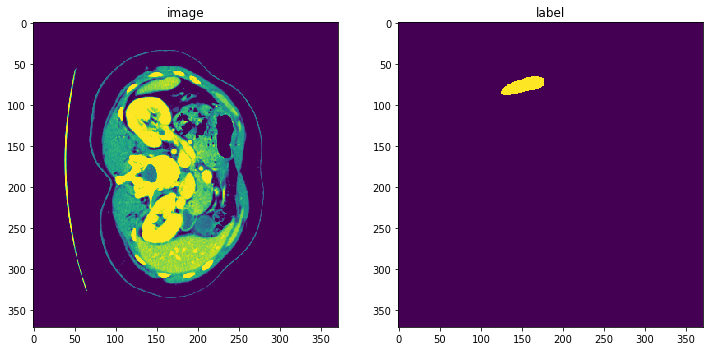

In [5]:
check_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
image, label = (check_data['image'][0][0], check_data['label'][0][0])
print('image shape:', image.shape, 'label shape:', label.shape)
# plot the slice [:, :, 100]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 100])
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 100])
plt.show()

## Define Dataset and DataLoader for training and validation

In [6]:
# create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=list_data_collate)
# create a validation data loader
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

## Create Model, Loss, Optimizer

In [7]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = monai.networks.nets.UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                                 strides=(2, 2, 2, 2), num_res_units=2, instance_norm=False).to(device)
loss_function = monai.losses.DiceLoss(do_softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [ ]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(600):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch + 1, 600))
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (batch_data['image'].to(device), batch_data['label'].to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print("%d/%d,train_loss:%0.4f" % (step, len(train_ds) // train_loader.batch_size, loss.item()))
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print("epoch %d average loss:%0.4f" % (epoch + 1, epoch_loss))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.
            metric_count = 0
            for val_data in val_loader:
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_data['image'], roi_size, sw_batch_size, model, device)
                val_labels = val_data['label'].to(device)
                value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                         to_onehot_y=True, mutually_exclusive=True)
                for batch in value:
                    metric_count += 1
                    metric_sum += batch.item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print("current epoch %d current mean dice: %0.4f best mean dice: %0.4f at epoch %d"
                  % (epoch + 1, metric, best_metric, best_metric_epoch))
print('train completed, best_metric: %0.4f  at epoch: %d' % (best_metric, best_metric_epoch))

## Plot the loss and metric

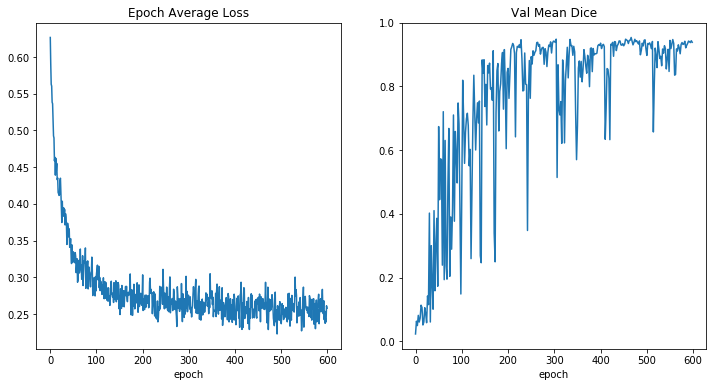

In [9]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * i for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

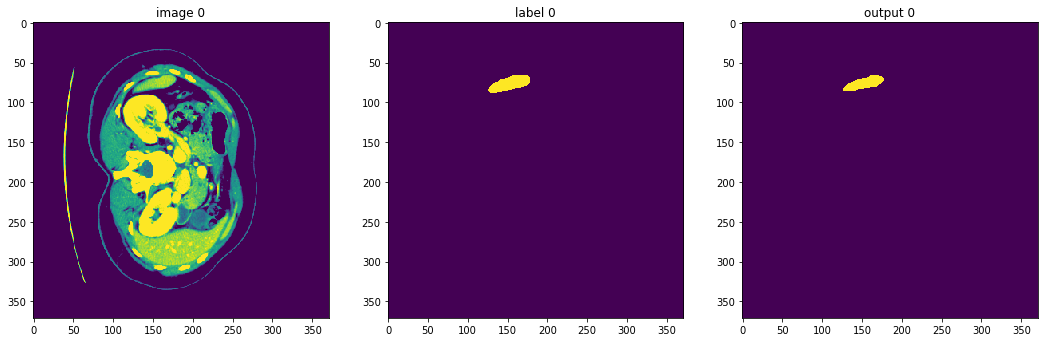

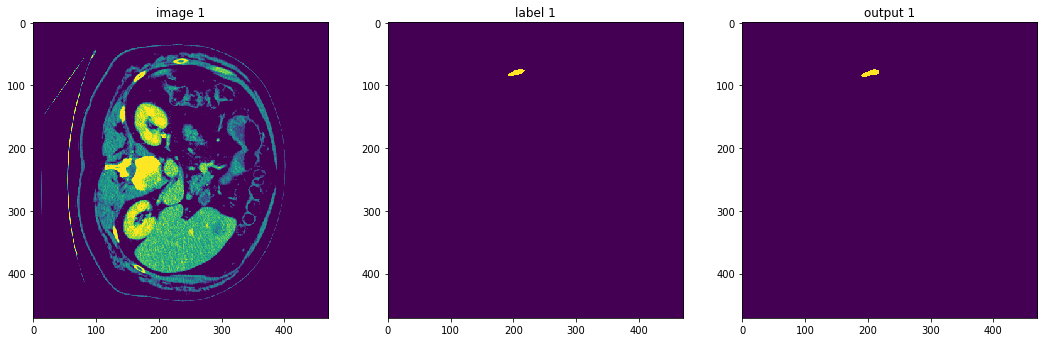

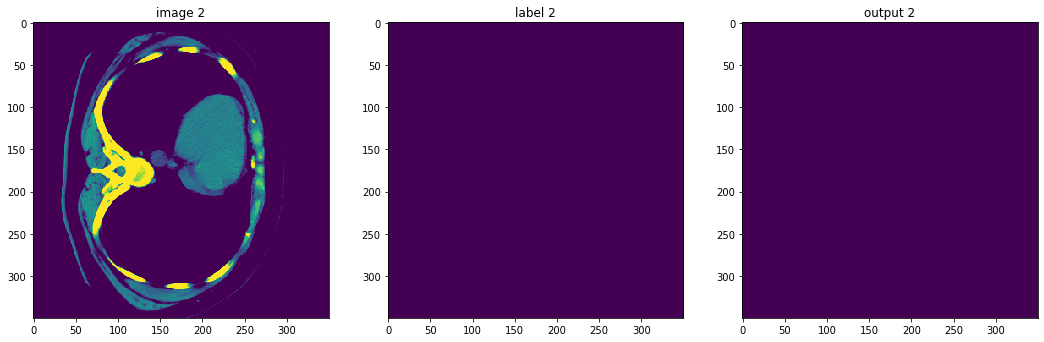

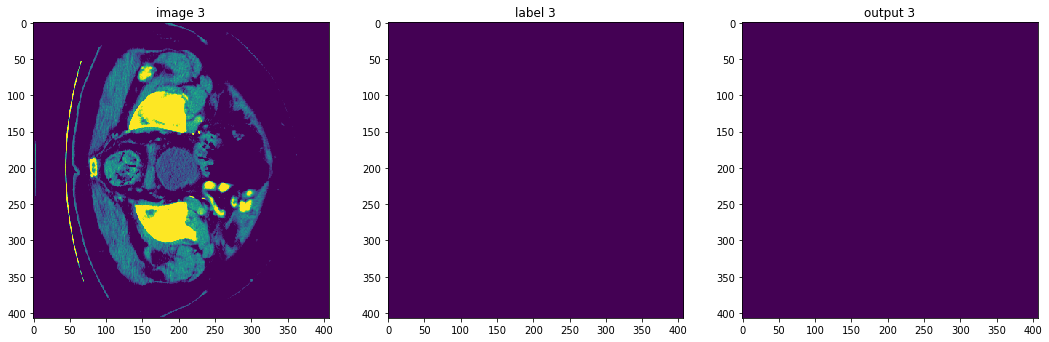

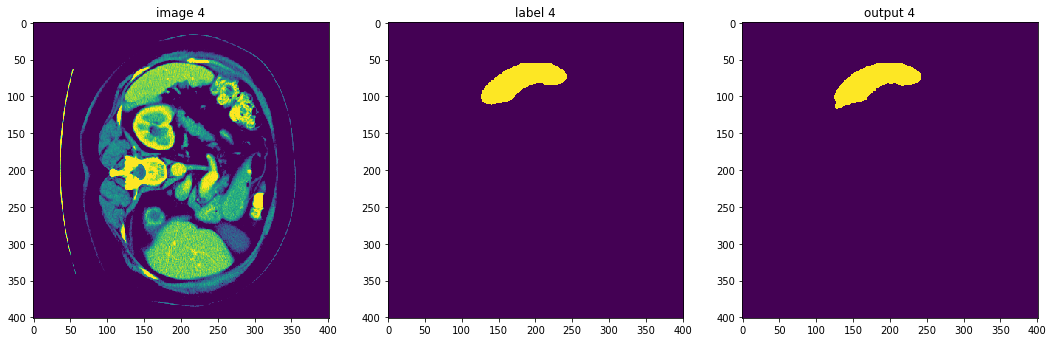

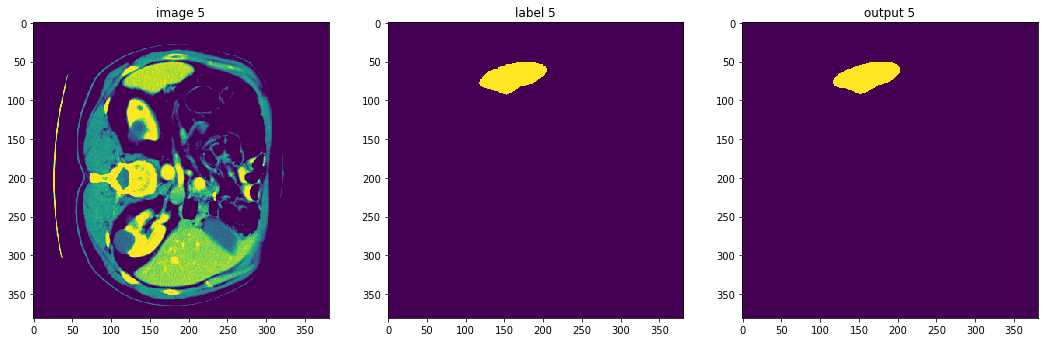

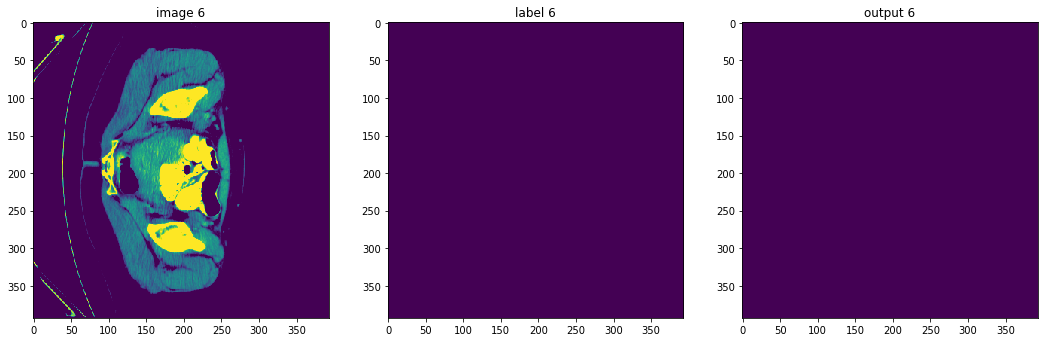

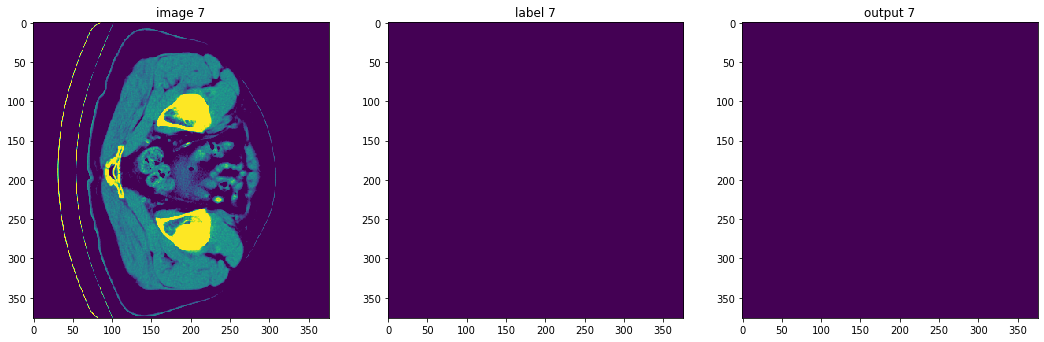

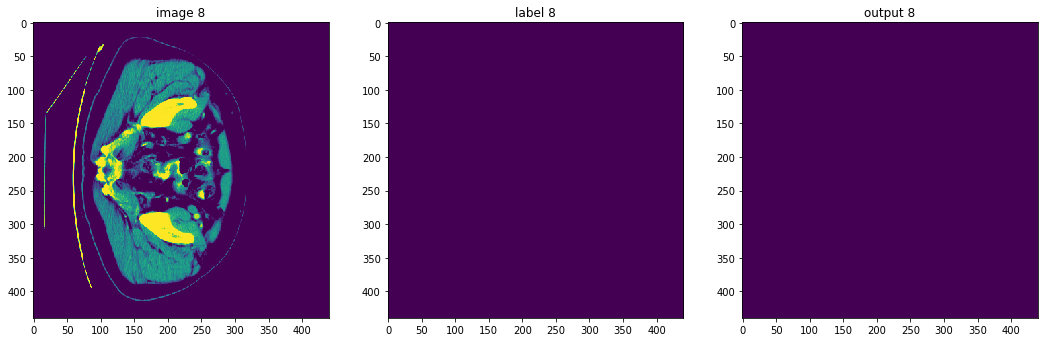

In [15]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data['image'], roi_size, sw_batch_size, model, device)
        # plot the slice [:, :, 100]
        plt.figure('check', (18, 6))
        plt.subplot(1, 3, 1)
        plt.title('image ' + str(i))
        plt.imshow(val_data['image'][0, 0, :, :, 100])
        plt.subplot(1, 3, 2)
        plt.title('label ' + str(i))
        plt.imshow(val_data['label'][0, 0, :, :, 100])
        plt.subplot(1, 3, 3)
        plt.title('output ' + str(i))
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 100])
        plt.show()